<a href="https://colab.research.google.com/github/Bibhash123/competition_quickstart_dataloader/blob/main/autoencoder-models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from IPython.display import clear_output
!pip install -U layer
clear_output(wait = False)

In [ ]:
import layer
from layer.decorators import dataset,model, pip_requirements, resources
layer.login()

In [ ]:
layer.init("rci-competition")

Your Layer project is here: https://app.layer.ai/bibhash/rci-competition

## Imports

In [1]:
import os
import gc
from tqdm.notebook import tqdm
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot
import seaborn as sns
import pandas as pd
import numpy as np
import scipy as sp
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning)

In [2]:
def rank_data(series):
    return (series.rank() - 1) / (len(series) - 1)

# **Data Preparation**

In [3]:
import os
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
!wget https://rocketcompetition.mypinata.cloud/ipfs/QmPGWzSzxtPBEoFFxKr3n5ja7K8yiJTnCNqbNbH1EZsZUg
!unzip -q QmPGWzSzxtPBEoFFxKr3n5ja7K8yiJTnCNqbNbH1EZsZUg -d "/content/"
!rm -r QmPGWzSzxtPBEoFFxKr3n5ja7K8yiJTnCNqbNbH1EZsZUg

--2022-07-06 11:56:37--  https://rocketcompetition.mypinata.cloud/ipfs/QmPGWzSzxtPBEoFFxKr3n5ja7K8yiJTnCNqbNbH1EZsZUg
Resolving rocketcompetition.mypinata.cloud (rocketcompetition.mypinata.cloud)... 104.18.30.237, 104.18.31.237, 2606:4700::6812:1eed, ...
Connecting to rocketcompetition.mypinata.cloud (rocketcompetition.mypinata.cloud)|104.18.30.237|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 361466596 (345M) [application/zip]
Saving to: ‘QmPGWzSzxtPBEoFFxKr3n5ja7K8yiJTnCNqbNbH1EZsZUg’

QmPGWzSzxtPBEoFFxKr 100%[===================>] 344.72M  96.6MB/s    in 3.8s    

2022-07-06 11:56:42 (91.1 MB/s) - ‘QmPGWzSzxtPBEoFFxKr3n5ja7K8yiJTnCNqbNbH1EZsZUg’ saved [361466596/361466596]



### Loading train_dataset and validation_dataset

In [5]:
train_dataset  = pd.read_csv('/content/dataset/train_dataset.csv', index_col = 'date')
validation_dataset  = pd.read_csv('/content/dataset/validation_dataset.csv', index_col = 'date')
print("Shape of train set:",train_dataset.shape)
print("Shape of test set:",validation_dataset.shape)

Shape of train set: (81895, 2013)
Shape of test set: (719, 2013)


In [6]:
train_dataset = train_dataset.sort_values(by=["symbol","date"]).reset_index(drop=False)
validation_dataset = validation_dataset.sort_values(by=["symbol","date"]).reset_index(drop=False)

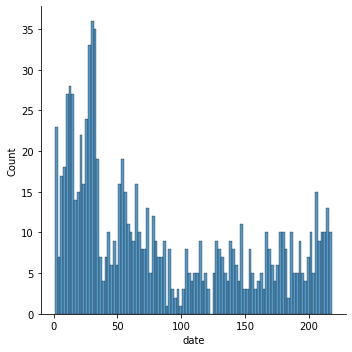

In [7]:
df = train_dataset.groupby("symbol")['date'].count().to_frame().reset_index()
sns.displot(df['date'],bins = 100)

In [8]:
# first column (symbol) is the ticker
# 'target_DC1' is the log of return for delta between current close to previous close
# 'target' is the y which is ranked by Era using 'target_DC1'
# the rest of the columns are features to be used for ML
train_dataset.head()

,date,symbol,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_2003,feature_2004,feature_2005,feature_2006,feature_2007,feature_2008,feature_2009,feature_DC1,target,target_DC1
0,2018-12-23,0xBTC,0.974026,0.987013,0.978355,0.991342,0.982684,0.982684,0.982684,0.978355,...,0.887446,0.857143,0.857143,0.857143,0.835498,0.839827,0.839827,0.891775,0.095238,-0.211551
1,2018-12-30,0xBTC,0.016878,0.033755,0.949367,0.936709,0.978903,0.907173,0.962025,0.953586,...,0.936709,0.953586,0.962025,0.932489,0.940928,0.945148,0.915612,0.101266,0.046414,-0.192849
2,2019-01-06,0xBTC,0.158996,0.016736,0.033473,0.928870,0.868201,0.941423,0.740586,0.933054,...,0.891213,0.874477,0.857741,0.912134,0.849372,0.807531,0.878661,0.050209,0.284519,-0.263822
3,2019-01-13,0xBTC,0.737500,0.279167,0.020833,0.054167,0.945833,0.908333,0.962500,0.870833,...,0.645833,0.600000,0.541667,0.691667,0.591667,0.504167,0.670833,0.287500,0.391667,0.023985
4,2019-01-20,0xBTC,0.983607,0.987705,0.983607,0.430328,0.971311,0.991803,0.987705,0.991803,...,0.504098,0.454918,0.422131,0.553279,0.368852,0.331967,0.450820,0.397541,0.032787,-0.251842


In [9]:
symbols = train_dataset.symbol.unique()
trainsize = train_dataset.shape[0]
train_dataset = pd.concat([train_dataset, validation_dataset], axis = 0)
train_dataset['dc1_lag1'] = -1
train_dataset['dc1_lag2'] = -1
train_dataset['target_lag1'] = -1
train_dataset['target_lag2'] = -1
for sym in tqdm(symbols):
  train_dataset.loc[train_dataset['symbol']==sym,'dc1_lag1'] = train_dataset[train_dataset['symbol']==sym]['target_DC1'].shift(1)
  train_dataset.loc[train_dataset['symbol']==sym,'dc1_lag2'] = train_dataset[train_dataset['symbol']==sym]['target_DC1'].shift(2)
  train_dataset.loc[train_dataset['symbol']==sym,'target_lag1'] = train_dataset[train_dataset['symbol']==sym]['target'].shift(1)
  train_dataset.loc[train_dataset['symbol']==sym,'target_lag2'] = train_dataset[train_dataset['symbol']==sym]['target'].shift(2)

train_dataset.fillna(-1,inplace = True)
train_dataset['month'] = pd.to_datetime(train_dataset['date']).apply(lambda x: x.month)
train_dataset['year'] = pd.to_datetime(train_dataset['date']).apply(lambda x: x.year)
train_dataset['day'] = pd.to_datetime(train_dataset['date']).apply(lambda x: x.day)

validation_dataset = train_dataset.iloc[trainsize:]
train_dataset = train_dataset.iloc[:trainsize]

  0%|          | 0/964 [00:00<?, ?it/s]

### Create X and y from train_dataset

### Each era representing a set of cryptocurrency assets for the time period, the number of assets within each Era is different

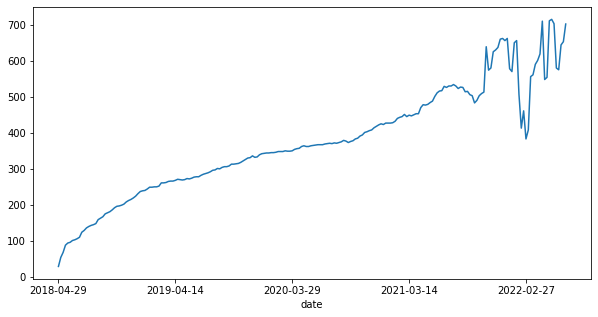

In [10]:
train_dataset.groupby(train_dataset.date).count().iloc[:,1].plot(figsize = (10,5));

### Split dataset into train and test by era

In [11]:
# Run Once
train = 0.9
test = 0.1
dates = sorted(train_dataset.date.unique())
era = len(dates)
train_era = int(era * train)
test_era = era - train_era
print('total Era: {}'.format(era))
print('train Era: {}'.format(train_era))
print('validation Era: {}'.format(test_era))

total Era: 218
train Era: 196
validation Era: 22


In [12]:
#split train and test set according to the train_era and test_era
# Run Once
train_set = train_dataset.loc[train_dataset.date < dates[train_era]]
val_set = train_dataset.loc[train_dataset.date >= dates[train_era]]
print('Train dataset shape: {}'.format(train_set.shape))
print('Validation dataset shape: {}'.format(val_set.shape))

Train dataset shape: (69023, 2021)
Validation dataset shape: (12872, 2021)


In [13]:
train_set.to_csv("train_set.csv",index = False)
val_set.to_csv("val_set.csv",index = False)
validation_dataset.to_csv("test_set.csv",index = False)

In [ ]:
os.kill(os.getpid(), 9)

In [4]:
train_set = pd.read_csv("train_set.csv")
val_set = pd.read_csv("val_set.csv")
validation_dataset= pd.read_csv("test_set.csv")

In [5]:
import tensorflow as tf
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K

def buildModel(num_inputs):
  inp = L.Input((num_inputs,))
  
  encoder = tf.keras.Sequential([
                                 L.Dense(1024, activation = "tanh"),
                                 L.Dense(256, activation = "tanh"),
                                 L.Dense(128, activation = "tanh", name = "encoded_output")
  ], name = "encoder")

  decoder = tf.keras.Sequential([
                                 L.Dense(256, activation = "tanh"),
                                 L.Dense(1024, activation = "tanh"),
                                 L.Dense(num_inputs, activation = "linear", name = "reconstructed")
  ], name = "Decoder")

  prediction_head = tf.keras.Sequential([
                                         L.Dense(128, activation = "tanh"),
                                         L.BatchNormalization(),
                                         L.Dropout(0.1),
                                         L.Dense(32, activation = "tanh"),
                                         L.BatchNormalization(),
                                         L.Dropout(0.1),
                                         L.Dense(1, activation = "linear", name = "regression_output")
  ], name = "predicted_target")

  h = encoder(inp)
  h1 = prediction_head(h)
  h2 = decoder(h)

  model = tf.keras.Model(inputs = inp, outputs = [h1,h2])
  model.compile(loss = {'Decoder':'mse', 'predicted_target': 'mae'}, optimizer = "adam")
  return model


def fitAutoEncoder():
  X_train = train_set.drop(['date','symbol','target','target_DC1'], axis = 1)
  Y_train = train_set['target_DC1']

  X_val = val_set.drop(['date','symbol','target','target_DC1'], axis = 1)
  Y_val = val_set['target_DC1']

  ckpt = tf.keras.callbacks.ModelCheckpoint('model.hdf5', monitor = "val_Decoder_loss", mode = "min",
                                            save_best_only = True, save_weights_only = True)
  es = tf.keras.callbacks.EarlyStopping(monitor = "val_Decoder_loss", mode = "min", patience = 5)

  autoencoder = buildModel(X_train.shape[1])
  print(autoencoder.summary())
  autoencoder.fit(X_train,(Y_train,X_train), epochs = 10,batch_size = 32,
          validation_data=(X_val,(Y_val,X_val)),
          callbacks = [ckpt,es]
        ) 
  autoencoder.load_weights('model.hdf5')
  print("Loss:", mean_squared_error(autoencoder.predict(X_val)[0], Y_val, squared = False))
  return autoencoder

autoencoder = fitAutoEncoder()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 2017)]       0           []                               
                                                                                                  
 encoder (Sequential)           (None, 256)          2722560     ['input_1[0][0]']                
                                                                                                  
 predicted_target (Sequential)  (None, 1)            37697       ['encoder[0][0]']                
                                                                                                  
 Decoder (Sequential)           (None, 2017)         2724321     ['encoder[0][0]']                
                                                                                              

In [6]:
def buildEncoder(autoencoder):

  inp = L.Input((autoencoder.input_shape[1],))
  
  encoder = tf.keras.Sequential([
                                 L.Dense(1024, activation = "tanh"),
                                 L.Dense(256, activation = "tanh"),
                                 L.Dense(128, activation = "tanh", name = "encoded_output")
  ], name = "encoder")

  h = encoder(inp)
  model = tf.keras.Model(inputs = inp, outputs = h)
  for idx,layers in enumerate(model.layers):
    model.layers[idx].set_weights(autoencoder.layers[idx].get_weights())

  return model

In [7]:
encoder = buildEncoder(autoencoder)

In [8]:
from xgboost import XGBRegressor

params = {'objective' : "reg:squarederror", 
          'n_estimators' : 1000, 
          'tree_method' : "gpu_hist", 
          'learning_rate': 0.03,                                                                                                                                                                                                                                                                                                                                                                                                                                                                    
          'reg_alpha':0.1,
          'reg_lambda':0.01,
          'subsample': 0.8,
          'colsample_bytree':0.8,
          'colsample_bylevel':0.8,
          'max_depth':9, 
          "reg_alpha":0.01
          }
def fitXGB():
  X_train = encoder.predict(train_set.drop(['date','symbol','target','target_DC1'], axis = 1))
  Y_train = train_set['target_DC1']

  X_val = encoder.predict(val_set.drop(['date','symbol','target','target_DC1'], axis = 1))
  Y_val = val_set['target_DC1']

  assert X_train.shape[1] == 256, 'Incorrect shape {}'.format(X_train.shape[1])
  reg = XGBRegressor(**params)
  reg.fit(X_train,Y_train, eval_metric = "rmse",
          eval_set=[(X_train,Y_train),(X_val,Y_val)], 
          early_stopping_rounds = 10)
  return reg

reg = fitXGB()

[0]	validation_0-rmse:0.562885	validation_1-rmse:0.577028
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:0.549823	validation_1-rmse:0.563317
[2]	validation_0-rmse:0.537261	validation_1-rmse:0.549992
[3]	validation_0-rmse:0.525141	validation_1-rmse:0.537119
[4]	validation_0-rmse:0.513545	validation_1-rmse:0.5247
[5]	validation_0-rmse:0.502343	validation_1-rmse:0.512806
[6]	validation_0-rmse:0.491613	validation_1-rmse:0.50119
[7]	validation_0-rmse:0.481307	validation_1-rmse:0.49
[8]	validation_0-rmse:0.47141	validation_1-rmse:0.47923
[9]	validation_0-rmse:0.461791	validation_1-rmse:0.468758
[10]	validation_0-rmse:0.452661	validation_1-rmse:0.458683
[11]	validation_0-rmse:0.443825	validation_1-rmse:0.449137
[12]	validation_0-rmse:0.435321	validation_1-rmse:0.439772
[13]	validation_0-rmse:0.427172	validation_1-rmse:0.430764
[14]	validation_0-rmse:0.419383	va

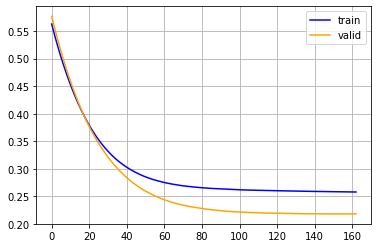

In [9]:
evals = reg.evals_result()
evaluation_plot = plt.figure()
plt.grid()
plt.plot(evals['validation_0']['rmse'],c='blue',label = 'train')
plt.plot(evals['validation_1']['rmse'],c='orange',label = 'valid')
plt.legend()

In [10]:
def predictFunction(xgb, encoder, dataset):
  files = dataset.copy()
  xgb_pred = xgb.predict(encoder.predict(files.drop(['date','symbol','target','target_DC1'], axis = 1)))

  files.loc[:,'predicted_DC1'] = xgb_pred.reshape((-1,1))/2
  files.loc[:,'predicted_target'] = -1
  for date in files.date.unique():
    files.loc[files['date']==date,'predicted_target'] = rank_data(files[files['date']==date]['predicted_DC1'])
  return files[['symbol','date','predicted_target']]

In [11]:
# function to calculate Spearman correlation by era (mean, std, max, min)
# we want to maximize but maintain stable correlation across era to maximize both challenge and competition reward
def spearman_by_era(prediction,target, dates):
  df = pd.DataFrame(index=dates,
                    data = {'prediction': prediction,
                            'target': target}
                    )
  spearman_era_list = []
  for era in df.index.unique():
    era_df = df[df.index == era]
    spearman_corr = sp.stats.spearmanr(era_df.prediction, era_df.target)[0]
    spearman_era_list.append(spearman_corr)

  mean = np.mean(spearman_era_list)
  std = np.std(spearman_era_list)
  max = np.max(spearman_era_list)
  min = np.min(spearman_era_list)
  return mean, std, max, min
  

In [12]:
pred_train = predictFunction(reg, encoder, train_set)
train_spearman = spearman_by_era(pred_train['predicted_target'].values, train_set['target'].values,
                                pred_train['date'].values)

print('Train dataset Spearman correlation: mean = {} ; std = {} ; max = {} ; min = {}'.format(round(train_spearman[0], 4), 
                                                                                            round(train_spearman[1], 4),
                                                                                            round(train_spearman[2], 4),
                                                                                            round(train_spearman[3], 4),
                                                                                            ))


Train dataset Spearman correlation: mean = 0.1617 ; std = 0.0765 ; max = 0.4198 ; min = -0.0119


In [13]:
pred_val = predictFunction(reg, encoder, val_set)
test_spearman = spearman_by_era(pred_val['predicted_target'].values, val_set['target'].values,
                                pred_val['date'].values)
print('Test dataset Spearman correlation: mean = {} ; std = {} ; max = {} ; min = {}'.format(round(test_spearman[0], 4),
                                                                                            round(test_spearman[1], 4),
                                                                                            round(test_spearman[2], 4),
                                                                                            round(test_spearman[3], 4),
                                                                                            ))


Test dataset Spearman correlation: mean = 0.0125 ; std = 0.0751 ; max = 0.1728 ; min = -0.1137


In [ ]:
mse = mean_squared_error(pred_val['predicted_target'],val_set['target'])
mae = mean_absolute_error(pred_val['predicted_target'],val_set['target'])
rmse = mean_squared_error(pred_val['predicted_target'],val_set['target'], squared = False)

In [ ]:
error = train_set[['symbol','date','target','target_DC1']].copy()
error['error'] = (error['target_DC1']-reg.predict(train_set.drop(['date','symbol','target','target_DC1'], axis = 1)))**2
error

,symbol,date,target,target_DC1,error
0,0xBTC,2018-12-23,0.095238,-0.211551,0.020716
1,0xBTC,2018-12-30,0.046414,-0.192849,0.050275
2,0xBTC,2019-01-06,0.284519,-0.263822,0.022225
3,0xBTC,2019-01-13,0.391667,0.023985,0.000503
4,0xBTC,2019-01-20,0.032787,-0.251842,0.053049
...,...,...,...,...,...
69018,ZYN,2021-12-12,0.906061,0.084073,0.019814
69019,ZYN,2021-12-19,0.108761,-0.072964,0.002691
69020,ZYN,2021-12-26,0.727134,0.001455,0.000722
69021,ZYN,2022-01-02,0.984894,0.447752,0.286530


In [ ]:
error[error['error']==np.max(error['error'])]

,symbol,date,target,target_DC1,error
40535,NCASH,2020-11-22,0.997549,1.78524,1.655016


In [ ]:
error[error['error']==np.min(error['error'])]

,symbol,date,target,target_DC1,error
46900,POE,2018-12-02,0.651163,-0.162674,1.483642e-12


In [ ]:
error[["target","target_DC1","error"]].corr()

,target,target_DC1,error
target,1.000000,0.673111,0.106583
target_DC1,0.673111,1.000000,0.258484
error,0.106583,0.258484,1.000000


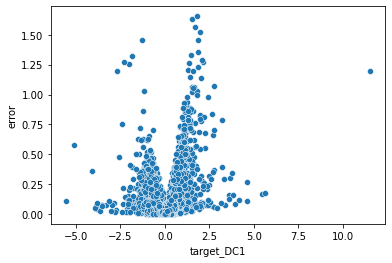

In [ ]:
error_plot = plt.figure()
sns.scatterplot(x = "target_DC1", y = "error", data = error)

[INFO] Number of important features: 2017


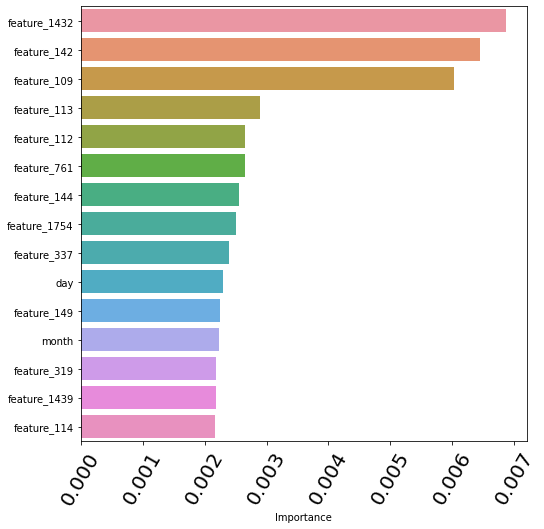

In [ ]:
importance = reg.feature_importances_
importances_rfc_df = pd.DataFrame(importance, index=train_set.drop(['date','symbol','target','target_DC1'], axis = 1).columns, columns=['Importance'])
importances_rfc_df = importances_rfc_df.sort_values(by='Importance', ascending=False)
importances_rfc_df = importances_rfc_df[importances_rfc_df['Importance'] > 0]
print("[INFO] Number of important features:",importances_rfc_df.shape[0])
importances_rfc_df = importances_rfc_df.head(15)

plt.figure(figsize=(8,8))
plt.xticks(rotation=60, fontsize = 20)
sns.barplot(y=importances_rfc_df.index, x=importances_rfc_df['Importance'])


In [ ]:
@model("xgb_model")
def train_function():  
    importance = reg.feature_importances_
    importances_rfc_df = pd.DataFrame(importance, index=train_set.drop(['date','symbol','target','target_DC1'], axis = 1).columns, columns=['Importance'])
    importances_rfc_df = importances_rfc_df.sort_values(by='Importance', ascending=False)
    importances_rfc_df = importances_rfc_df[importances_rfc_df['Importance'] > 0]
    print("[INFO] Number of important features:",importances_rfc_df.shape[0])
    importances_rfc_df = importances_rfc_df.head(15)

    plt.figure(figsize=(8,8))
    plt.xticks(rotation=60, fontsize = 20)
    sns.barplot(y=importances_rfc_df.index, x=importances_rfc_df['Importance'])
    
    
    layer.log(params)
    layer.log({'Mean Absolute Error':mae})
    layer.log({'Mean Squarred Error': mse})
    layer.log({'Root Mean Squared Error': rmse})
    layer.log({"Train mean pearson":round(train_spearman[0], 4)})
    layer.log({"Train std pearson":round(train_spearman[1], 4)})
    layer.log({"Validation mean pearson":round(test_spearman[0], 4)})
    layer.log({"Validation std pearson":round(test_spearman[1], 4)})
    layer.log({"Feature importance": plt.gcf()})
    layer.log({"Training metrics": evaluation_plot})
    layer.log({"Error Plot":error_plot})
    plt.show()
    return reg

reg = train_function()

Output()

[INFO] Number of important features: 2012

In [ ]:
pred_submission = predictFunction(reg, encoder, validation_dataset)

In [ ]:
# Use the trained Linear Regression model to make prediction on latest data
# X_validation = validation_dataset.iloc[:, 1:-2]
# y_validation_linear_reg = reg.predict(X_validation)
y_validation_linear_reg = pred_submission['predicted_target'].values
y_validation_linear_reg[:5]

array([0.85376045, 0.56406685, 0.74233983, 0.045961  , 0.48885794])

### Let's use the prediction from linear regression to join with validation dataset symbol for submission

In [ ]:
prediction = pd.DataFrame()
prediction['symbol'] = list(pred_submission.symbol)
prediction['prediction'] = y_validation_linear_reg

# sort the prediction to check which symbol is weaker and stronger, ie. FOX is weakest; BTC is strongest
prediction.sort_values('prediction')

,symbol,prediction
707,YTSLA,0.000000
601,SWRV,0.001393
173,DGD,0.002786
57,BASE,0.004178
224,EVX,0.005571
...,...,...
8,ABX,0.994429
701,YFFII,0.995822
611,TITAN,0.997214
659,VGX,0.998607


### Check is prediction dataframe in accordance for submission format (using the prediction from linear regression)

In [ ]:
#check if y_latest is in accordance to shape for submission
if set(prediction.symbol) == set(validation_dataset.symbol):
    print('symbol matched!')
else:
    print('symbol unmatched, the symbol in prediction df must match the symbol in validation_dataset...')
    
if prediction.shape[1] == 2:
    print('column counts ok!')
else:
    print('It should have 2 columns, first column with symbol, second with prediction...')


symbol matched!
column counts ok!


### Output prediction as a .csv file for submission!

In [ ]:
#Output submission as .csv file
#The prediction.csv is stored in content/prediction folder
import os
if not os.path.exists('/content/prediction'):
    os.makedirs('/content/prediction')
prediction.to_csv('/content/prediction/prediction.csv', index = False, header = None)

# **Submission Section**

## **Setup**

In [ ]:
!git clone https://github.com/rocketcapital-ai/competition_submission.git
%cd /content/competition_submission

Cloning into 'competition_submission'...
remote: Enumerating objects: 23, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 23 (delta 3), reused 19 (delta 3), pack-reused 0
Unpacking objects: 100% (23/23), done.
/content/competition_submission


In [ ]:
!pip install base58
!pip install PyYAML
!pip install requests
!pip install web3
!pip install pandas 
from IPython.display import clear_output
clear_output(wait = False)

In [ ]:
from lib.submitter import *

jwt = 'eyJhbGciOiJIUzI1NiIsInR5cCI6IkpXVCJ9.eyJ1c2VySW5mb3JtYXRpb24iOnsiaWQiOiIxMDIwZDY0OC1kNzQ5LTQ5YjItOTZmZS1hNWQ0NDY5ODRjNTQiLCJlbWFpbCI6ImJpYmhhc2hwLmRhc0BnbWFpbC5jb20iLCJlbWFpbF92ZXJpZmllZCI6dHJ1ZSwicGluX3BvbGljeSI6eyJyZWdpb25zIjpbeyJpZCI6IkZSQTEiLCJkZXNpcmVkUmVwbGljYXRpb25Db3VudCI6MX0seyJpZCI6Ik5ZQzEiLCJkZXNpcmVkUmVwbGljYXRpb25Db3VudCI6MX1dLCJ2ZXJzaW9uIjoxfSwibWZhX2VuYWJsZWQiOmZhbHNlLCJzdGF0dXMiOiJBQ1RJVkUifSwiYXV0aGVudGljYXRpb25UeXBlIjoic2NvcGVkS2V5Iiwic2NvcGVkS2V5S2V5IjoiYmM4NWI0ZDQ1N2FhYWZlNzBmNGIiLCJzY29wZWRLZXlTZWNyZXQiOiJlMmEyOGFlZmFlNTcyMWZkNzM1Mjg4NzE5OTIzYTBkZTQ4MWY5NzUxZWQyZmVhMTE0MGJmYzRlNzNjNzRhYzI2IiwiaWF0IjoxNjU1MTM2Nzc4fQ.xl2FxgrL04kQIa7cIn89a_iE0I9xphiNf6K5K2mor5o'      # User-specified field.
address = '0xcF16365d53ed53055f39010830e3CcD5A7a8245E'  # User-specified field.
pk = '32316dfe607ed4a240ac29a6dcad9db6f484f0fbdf7894c15511237e1e13db70'       # User-specified field.
submitter = Submitter(jwt, address, pk)

## View wallet address information.

In [ ]:
print('MATIC balance for {}: {}'.format(submitter.address, submitter.get_matic_balance()))
print('MUSA balance for {}: {}'.format(submitter.address, submitter.get_musa_balance()))
print('Current stake for {}: {}'.format(submitter.address, submitter.get_stake()))

MATIC balance for 0xcF16365d53ed53055f39010830e3CcD5A7a8245E: 1.024154240957063615
MUSA balance for 0xcF16365d53ed53055f39010830e3CcD5A7a8245E: 0.869313545300001154
Current stake for 0xcF16365d53ed53055f39010830e3CcD5A7a8245E: 168.569365044100002658


## **Retrieve Dataset and run models.**
### Please follow the instructions and example found [here](https://github.com/rocketcapital-ai/competition_quickstart_dataloader).

### When completed, please place final prediction csv file in the `file_to_submit` folder.

In [ ]:
!cp "/content/prediction/prediction.csv" "/content/competition_submission/file_to_submit/"

## **Set stake.** (optional)
### Skip if no changes need to be made.

In [ ]:
# set_stake_amount = 125.00  # User-specified field.
# transaction_success = submitter.set_stake(set_stake_amount)
# assert transaction_success, 'Setting stake failed.'

Setting gas price to 65 gwei.
Sending transaction 0xe3cf8d0d27ab1452e097706b3ceb1c3bb6f4ab91c181af5e21588934c3d82469
Transaction sent. Tx ID: 0xe3cf8d0d27ab1452e097706b3ceb1c3bb6f4ab91c181af5e21588934c3d82469


## **Submit predictions.**
Note that the same `submit_prediction` method should be used for re-submitting predictions.

In [ ]:
submission_file_name = 'prediction.csv'  # User-specified field.
transaction_success = submitter.submit_prediction(submission_file_name)
assert transaction_success, 'Submission failed.'

Encrypting file.
Zipping encrypted file.
Uploading and recording on blockchain.
Setting gas price to 34 gwei.
Sending transaction 0xdb3bd6826acf44288960f678ecf3e23fe948095d442eeb4c42f4fdef14e62b61
Transaction sent. Tx ID: 0xdb3bd6826acf44288960f678ecf3e23fe948095d442eeb4c42f4fdef14e62b61


### **Retrieve and double-check predictions.** (optional)
This section retrieves your submitted files, decrypts them, and compares them to the original file in `file_to_submit`.

If the verification fails, please wait a few minutes and perform the verification again. If the problem persists, please re-submit your predictions.

In [ ]:
verification_success = submitter.download_and_check(submission_file_name)
assert verification_success, 'Submission verification failed.'
print('Files are identical. Verification check passed.')

Retrieving file.
File retrieved.
File unzipped.
File decrypted. Comparing files.
Removing temp files.
Temp files removed.
Files are identical. Verification check passed.
